#### Задание: 
Был проведен A/B тест, в рамках которого для новых пользователей дейтингового приложения
из нескольких стран была изменена стоимость премиум-подписки (деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит) при покупке через две новые
платежные системы. При этом стоимость пробного периода оставалась прежней.

#### Проверьте:
1.Был ли эксперимент успешен в целом.

2.Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

#### Имеются три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2)

#### ФАЙЛЫ:
•users_test – информация о пользователях в тестовой группе.
<br>•users_control_1 – информация о пользователях в первой контрольной группе.
<br>•users_control_2 – информация о пользователях во второй контрольной группе .
<br>•transactions_test – информация о платежах пользователей в тестовой группе.
<br>•transactions_control_1 – информация о платежах пользователей в первой контрольной группе.
<br>•transactions_control_2 – информация о платежах пользователей во второй контрольной группе

### users_*.csv – информация о пользователях:
<br>•uid – идентификатор пользователя
<br>•age – возраст
<br>•attraction_coeff – коэффициент привлекательности (от 0 до 1000)
<br>•coins – число монеток (внутренняя валюта)
<br>•country – страна
<br>•visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
<br>•gender – пол
<br>•age_filter_start  – фильтр поиска, мин. значение
<br>•age_filter_end  – фильтр поиска, макс. значение
<br>•views_count – число полученных оценок
<br>•was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
<br>•is_premium –  является ли премиум
<br>•total_revenue – нормированная выручка

### transactions_*.csv – информация о платежах пользователей:
•uid – идентификатор пользователя
<br>•country – страна
<br>•joined_at – дата и время регистрации
<br>•paid_at – дата и время покупки
<br>•revenue – нормированная выручка
<br>•payment_id – идентификатор платежа
<br>•from_page – откуда пользователь перешел на страницу оплаты
<br>•product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

## 1. Загрузка данных

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg
from pingouin import chi2_independence
from scipy import stats
import scipy.stats as ss
from scipy.stats import norm,mannwhitneyu

from tqdm import tqdm

In [2]:
#код сверху срабатывает через раз, поэтому оставлю это здесь

users_control_1 = pd.read_csv('users_control_1.csv', sep = ';')
users_control_2 = pd.read_csv('users_control_2.csv', sep = ';')

transactions_control_1 = pd.read_csv('transactions_control_1.csv', parse_dates=['joined_at','paid_at'], sep = ';')
transactions_control_2 = pd.read_csv('transactions_control_2.csv', parse_dates=['joined_at','paid_at'], sep = ';')

users_test= pd.read_csv('users_test.csv', sep = ';')
transactions_test= pd.read_csv('transactions_test.csv', parse_dates=['joined_at','paid_at'], sep = ';')


In [3]:
users_test.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0


In [4]:
users_control_1.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0


## 2. Проверка, очистка и подготовка данных

### Проверка пересечения юзеров в тесте и контроле

Для корректного проведения теста необходимо, чтобы один юзер попадал только в одну группу.

In [5]:
np.intersect1d(users_test.uid, users_control_1.uid)

array([], dtype=int64)

In [6]:
np.intersect1d(users_test.uid, users_control_2.uid)

array([], dtype=int64)

In [7]:
np.intersect1d(users_control_1.uid, users_control_2.uid)

array([], dtype=int64)

Пересечений не обнаружено

### Проверка корректности дат

Посмотрим, в какой период совершались транзакции (время проведения эксперимента)

In [8]:
transactions_test.paid_at.min()

Timestamp('2017-01-11 04:37:00')

In [9]:
transactions_test.paid_at.max()

Timestamp('2017-12-11 22:06:00')

In [10]:
(transactions_test.paid_at.max() - transactions_test.paid_at.min())

Timedelta('334 days 17:29:00')

Проверим, соответствует ли время регистрации пользователей. Нет ли тех, кто зарегистрировался позже, чем совершил транзакцию 

In [11]:
transactions_control_1.joined_at.max()

Timestamp('2017-10-31 22:17:00')

In [12]:
transactions_control_2.joined_at.max()

Timestamp('2017-10-31 17:43:00')

In [13]:
transactions_control_1.joined_at.min()

Timestamp('2015-01-19 11:49:00')

In [14]:
transactions_control_2.joined_at.min()

Timestamp('2017-01-11 08:36:00')

Как видно, в группе transactions_control_1 находятся данные о пользователях, зарегистрированных 2015 году, что не подходит под условия эксперимента. Уберем таких пользователей.

In [15]:
join_date = pd.to_datetime('2017-01-01')

In [16]:
transactions_control_1[transactions_control_1.joined_at < join_date]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


Это всего один пользователь, которого можно удалить

In [17]:
transactions_control_1 =transactions_control_1[transactions_control_1.uid != 960936960.0]

Проверим, нет ли записей, где транзакция была совершена до момента регистрации пользователя. Такие данные скорее всего будут ошибочно сформированными.

In [18]:
bad_log = transactions_control_1[transactions_control_1.joined_at > transactions_control_1.paid_at]
bad_log.shape

(55, 8)

In [19]:
bad_log2 = transactions_control_2[transactions_control_2.joined_at > transactions_control_2.paid_at]
bad_log2.shape

(60, 8)

In [20]:
bad_log3 = transactions_test[transactions_test.joined_at > transactions_test.paid_at]
bad_log3.shape

(47, 8)

In [21]:
bad_log.paid_at.dt.day.unique()

array([11])

In [22]:
bad_log2.paid_at.dt.day.unique()

array([11])

In [23]:
bad_log3.paid_at.dt.day.unique()

array([11])

Видим, что таких записей довольно много. Стоит разобраться с тем, как такое могло произойти и нет ли багов в логировании данных. Если обратить внимание на даты, то можно заметить, что во всех  датах фигурирует число 11 в качестве дня. Если предположить, что это мог бы быть месяц, тогда все встает на свои места - даты считаны неверно.  Можно переформатировать эти случаи в правильную дату, но поскольку мы не работаем со строгой временной последовательностью это не сильно принципиально. 

### Проверка на дубликаты

In [24]:
transactions_control_1[transactions_control_1.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [25]:
transactions_control_2[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins


In [26]:
transactions_test[transactions_test.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


In [27]:
transactions_test = transactions_test.drop_duplicates()
transactions_control_1 = transactions_control_1.drop_duplicates()
transactions_control_2 = transactions_control_2.drop_duplicates()

Среди данных users дубликаты не обнаружены. Сделаем проверку на выбросы и аномалии, так как они могут сильно виять на результаты теста.

### Проверка на пустые значения

In [28]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [29]:
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [30]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [31]:
#Заполним колонки coins, was_premium, is_premium нулями (вероятно, если эти поля не заполнены, то пользователь вряд ли является премиумом и имеет монетки
def filling_na(df):
    for col in ['coins', 'was_premium', 'is_premium']:
        df[col] = df[col].fillna(0)
    return df

In [32]:
users_test, users_control_1, users_control_2 = (filling_na(df) for df in [users_test, users_control_1, users_control_2])

In [33]:
transactions_control_1.isna().sum()

uid             1
country         1
joined_at       1
paid_at         1
revenue         1
payment_id      1
from_page       1
product_type    1
dtype: int64

In [34]:
transactions_control_1.dropna(inplace = True)

In [35]:
transactions_control_1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [36]:
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [37]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

### Проверка типов данных

In [38]:
transactions_control_1.dtypes

uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

In [39]:
transactions_control_1['uid'] = transactions_control_1['uid'].astype(int)

In [40]:
transactions_control_2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [41]:
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [42]:
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [43]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

### Проверка соответствия пользователей и их транзакций 

Проверим, что количество пользователей совпадает с данными о транзакциях, ими совершенных

In [44]:
tcr1 = transactions_control_1.groupby(['uid'], as_index = False).revenue.sum()
tcr1

,uid,revenue
0,891092322,9945.0
1,891120969,6292.0
2,891130164,11869.0
3,891131061,10075.0
4,891135642,962.0
...,...,...
187,892393119,3614.0
188,892405224,8424.0
189,892421277,60333.0
190,892421826,14586.0


In [45]:
ucr1 = users_control_1.query('total_revenue > 0').groupby(['uid'], as_index = False).total_revenue.sum()
ucr1

,uid,total_revenue
0,891092322,9945
1,891120969,6292
2,891130164,11869
3,891131061,10075
4,891135642,962
...,...,...
187,892405224,8424
188,892421277,60333
189,892421826,14586
190,892423284,12909


Количество пользователей совпадает, сравним общую сумму выручки


In [46]:
tcr1.revenue.sum() 

2493998.0

In [47]:
ucr1.total_revenue.sum()

2581267

Общая сумма выручки не совпадает, найдем этих пользователей, объединив датафреймы по uid

In [48]:
crr1 = tcr1.merge(ucr1, on = 'uid', how = 'inner')
crr1

,uid,revenue,total_revenue
0,891092322,9945.0,9945
1,891120969,6292.0,6292
2,891130164,11869.0,11869
3,891131061,10075.0,10075
4,891135642,962.0,962
...,...,...,...
186,892393119,3614.0,3614
187,892405224,8424.0,8424
188,892421277,60333.0,60333
189,892421826,14586.0,14586


In [49]:
crr1.query('revenue != total_revenue')

,uid,revenue,total_revenue
16,891252072,7553.0,8814
35,891320916,10075.0,13858
44,891365490,8814.0,10075
46,891367521,16081.0,20462
54,891452706,12597.0,18902
95,891721851,17277.0,18174
97,891739737,20163.0,21424
140,892102893,12610.0,25220
161,892207959,16380.0,18902
178,892333905,403104.0,486330


In [50]:
tcr2 = transactions_control_2.groupby(['uid'], as_index = False).revenue.sum()
tcr2

,uid,revenue
0,891068079,10296
1,891075072,2327
2,891077727,6292
3,891080040,15132
4,891112263,17290
...,...,...
182,892384110,9087
183,892385232,6292
184,892395564,2730
185,892435536,13598


In [51]:
ucr2 = users_control_2.query('total_revenue > 0').groupby(['uid'], as_index = False).total_revenue.sum()
ucr2

,uid,total_revenue
0,891068079,10296
1,891075072,2327
2,891077727,6292
3,891080040,15132
4,891112263,17290
...,...,...
182,892384110,9087
183,892385232,6292
184,892395564,2730
185,892435536,13598


In [52]:
tcr2.revenue.sum() 

1907997

In [53]:
ucr2.total_revenue.sum()

1920438

In [54]:
crr2 = tcr2.merge(ucr2, on = 'uid', how = 'outer')
crr2

,uid,revenue,total_revenue
0,891068079,10296,10296
1,891075072,2327,2327
2,891077727,6292,6292
3,891080040,15132,15132
4,891112263,17290,17290
...,...,...,...
182,892384110,9087,9087
183,892385232,6292,6292
184,892395564,2730,2730
185,892435536,13598,13598


In [55]:
crr2.query('revenue != total_revenue')

,uid,revenue,total_revenue
97,891862596,8814,10075
122,892009254,4719,7072
128,892045743,8814,10075
132,892062660,1261,2522
133,892064328,12597,18902


Экстремальных расхождений по выручке нет, так что будем работать с тем, что есть. Но на это определенно стоит обратить внимание руководства и лиц, непосредственно вовлеченных в сбор данных, возможно в системе сбора и хранения данных о транзакциях и пользователях присутствует ошибка.

### Проверка раcпределений признаков по группам

Проверим, насколько разделение "честное", то есть группы статистически не отличаются по распределению признаков, отличных от того, на который направлен эксперимент (выручка). Нужно убедиться, что нет такой ситуации, что в одну группу попадают только мужчины, в другую женщины, или в одной группе представлена одна возрастная группа, а во второй другая (в таком случае эффект, полученный в ходе теста, может быть обусловлен не самим нововведением, а другим признаком). Будем проверять статистически с помощью t-теста (так как группы достаточно большие) и подсчета p-value.

Для начала оценим распределения визуально, затем для спорных случаев применим статистический тест.

In [56]:
cols_to_check = [ 'age', 'attraction_coeff',  'coins', 'gender']

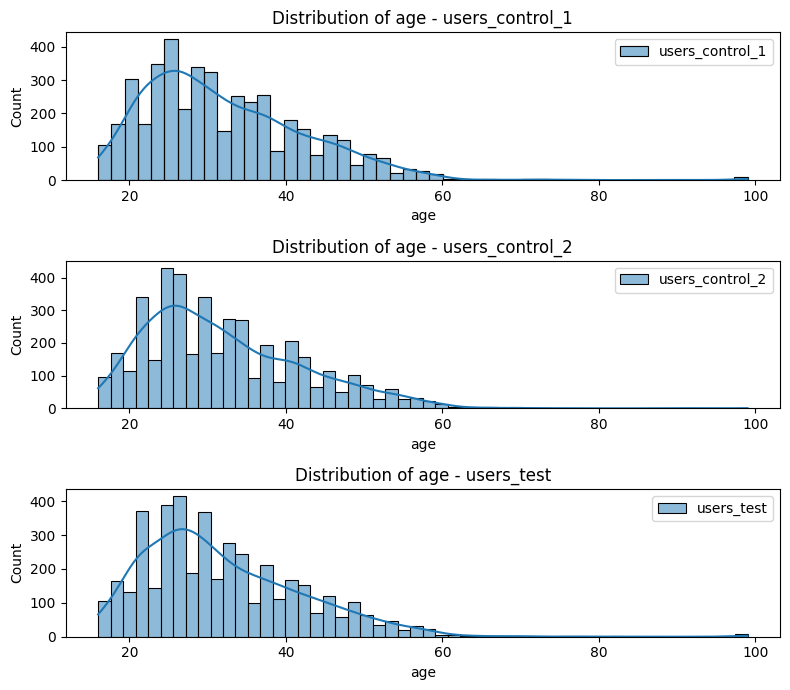

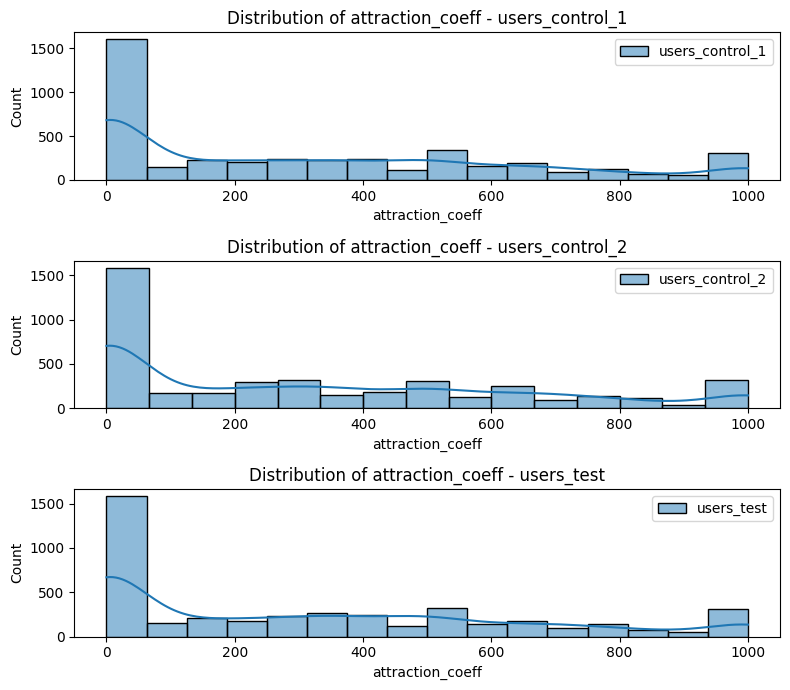

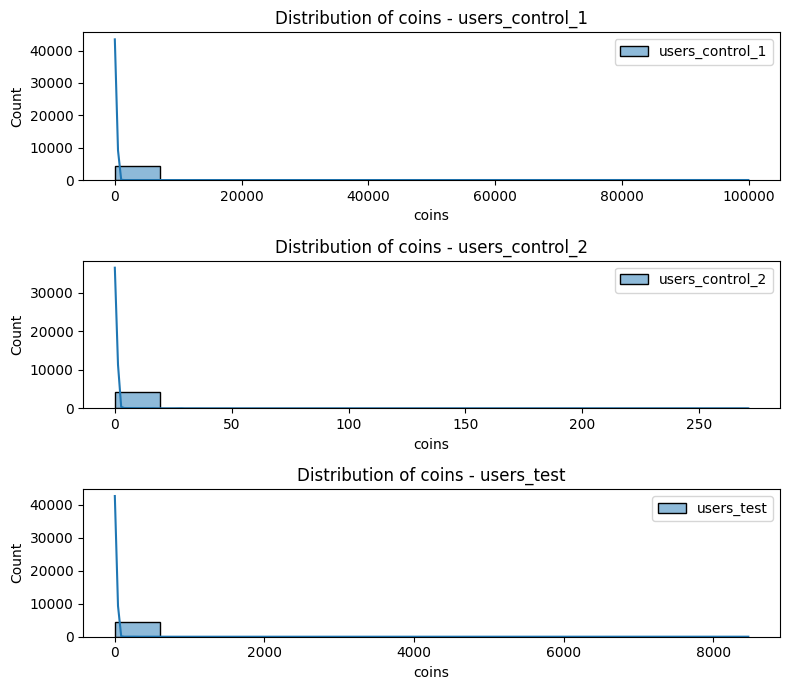

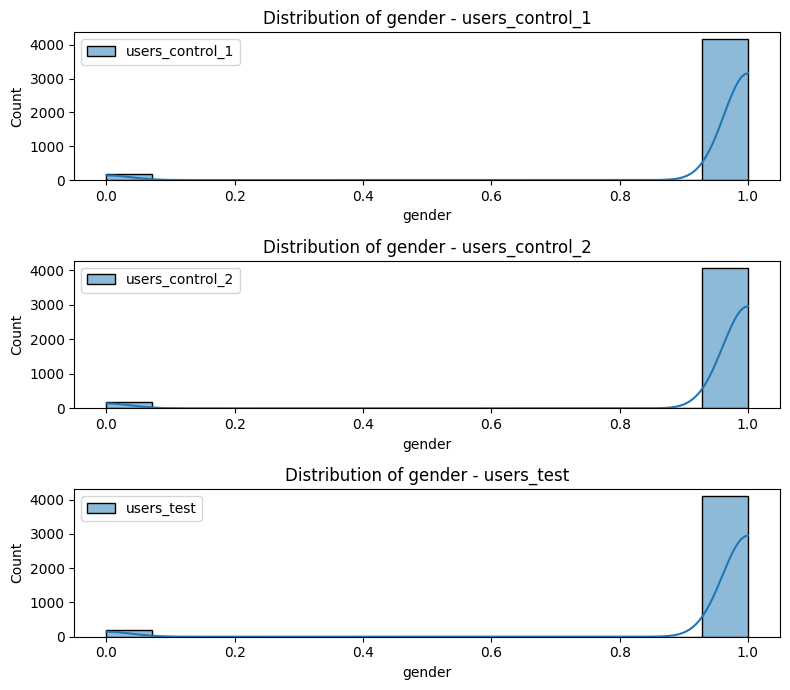

In [57]:
dfs = [users_control_1, users_control_2, users_test]
labels = ['users_control_1', 'users_control_2', 'users_test']

# Перебираем каждый признак и строим гистограмму для каждого датафрейма
for col in cols_to_check:
    plt.figure(figsize=(8, 7))
    for i in range(3):
        plt.subplot(3, 1, i+1)
        sns.histplot(dfs[i][col], kde=True, label=labels[i])
        plt.title(f'Distribution of {col} - {labels[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()

Вывод: можно видеть, что признаки распределены равномерно между группами.

### Проверка на выбросы

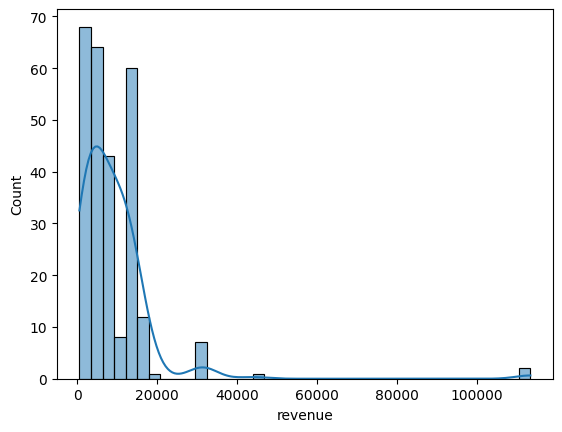

In [58]:
sns.histplot(transactions_test.revenue, kde=True);

Можно заметить отдельно стоящее значение выше 100000, которое можно отнести либо к выбросам, либо супер-премиум пользователям. Из текущих данных это трудно понять, поэтому попробуем выполнить тест как с присутствием данных юзеров в выборке, так и без них. Если будут получены значимые отличия с ними, а без них нет - то можно сделать вывод, что метрика выросла только за счет двух таких активных пользователей и стоит с осторожностью относиться к результатам такого теста, и возможно провести дополнительные проверки. Если же и в обоих раскладах получим результат, то удалять их не будем.

In [59]:
transactions_test[transactions_test.revenue > 100000]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial
196,892038759,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477,147,autoreply_message,premium_no_trial


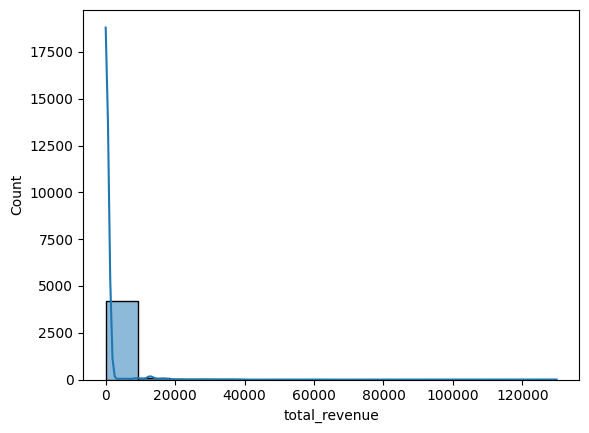

In [60]:
sns.histplot(users_test.total_revenue, kde=True);

In [61]:
users_test[users_test.total_revenue > 100000]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
992,892038759,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565
3629,891178380,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870


In [62]:
users_test_ = users_test[~users_test.uid.isin([892038759,891178380])]
transactions_test_ = transactions_test[~transactions_test.uid.isin([892038759,891178380])]

Аналогично проверим распределение выручки на пользователя в контроле 

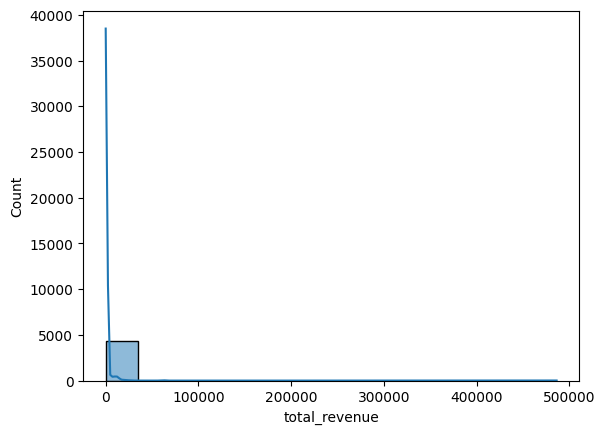

In [63]:
sns.histplot(users_control_1.total_revenue, kde=True);

In [64]:
users_control_1.query('total_revenue > 100000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330


In [65]:
users_control_1_ = users_control_1[users_control_1.uid != 892333905]

**Промежуточный вывод:** как показало дальнейшее проведение теста (A/A, A/B) как 'с', так и без удаления данных пользователей был также получен статистически значимый результат, поэтому их решено было оставить.

## 3. Проверка системы сплитования (A/A тест)

Проведем симуляцию A/A теста для целевой метрики и визуализируем распределение p-value для пользователей в контрольных группах

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 378.84it/s]


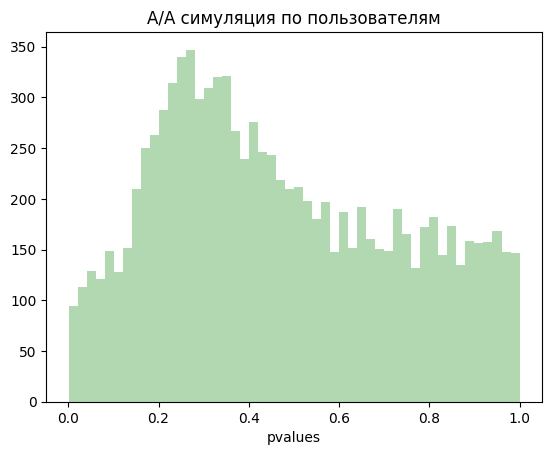

In [66]:
num_simulations = 10000
sample_size = 1000
p_vals = []

# Запуск симуляций A/A теста для выручки
for i in tqdm(range(num_simulations)):
    s_1 = users_control_1.total_revenue.sample(sample_size).values
    s_2 = users_control_2.total_revenue.sample(sample_size).values
    p_vals.append(stats.ttest_ind(s_1, s_2, equal_var = False)[1]) 

plt.hist(p_vals, bins = 50, color = 'green', alpha = 0.3)
plt.xlabel('pvalues')
plt.title("A/A симуляция по пользователям")
plt.show()

Небольшое возвышение на графике связано с решением не удалять супер-премиум пользователей, полученных на предыдущем этапе. Без них данный график выглядит более равномерным. Тем не менее сам тест сходится и с наличием данных пользователей в выборке.

In [67]:
(np.array(p_vals) < 0.05).mean()

0.0264

Количество ложноположительных случаев не превышает значения альфа, можно сделать вывод, что сплитование произведено корректно, и соединить в одну выборку контроль1 и контроль2:

In [68]:
users_control = pd.concat([users_control_1,users_control_2], axis = 0)
transactions_control = pd.concat([transactions_control_1,transactions_control_2], axis = 0)

In [69]:
users_control[users_control.total_revenue == 0]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,0.0,0.0,0
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,0.0,0.0,0
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,0.0,0.0,0
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,0.0,0.0,0
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,0.0,0.0,0
4260,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,0.0,0.0,0
4261,891096429,41,333,0.0,United States of America,NaN,1,38,44,6,0.0,0.0,0
4262,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,0.0,0.0,0


In [70]:
#объединим пользователей с транзакциями
all_control = users_control.merge(transactions_control, on = 'uid', how = 'outer')

In [71]:
all_control['exp_group'] = 'control'

In [72]:
all_test = users_test.merge(transactions_test, on = 'uid', how = 'outer')

In [73]:
all_test['exp_group'] = 'test'

In [74]:
all_data = pd.concat([all_control, all_test], axis = 0)

In [75]:
all_data.head(3)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,exp_group
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,...,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,...,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,...,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control


## 4. Страны, принимающие участие в эксперименте

Поскольку цены на премиум-подписку были изменены для новых пользователей из нескольких стран, но точные страны, в которых это произошло, не уточнены, нужно вывести эти страны на основе данных о совершенных покупках. Необходимо проверить, произошло ли повышение цен на премиум-подписку (premium_no_trial) в странах, по которым у нас есть данные о транзакциях.
Для этого сравним медианные значения по нормированной выручке по транзакциям для продукта premium_no_trial (медианные - так как они более устойчивы к экстремальным значениям).

In [76]:
all_data['country'] = all_data['country_x']

In [77]:
control_revenue_median = all_data[all_data.exp_group == 'control'] \
    .query('product_type == "premium_no_trial"')\
    .groupby('country', as_index=False)\
    .agg({'revenue': 'median'})\
    .rename(columns={'revenue': 'control_revenue_median'})

test_revenue_median = all_data[all_data.exp_group == 'test'] \
    .query('product_type == "premium_no_trial"')\
    .groupby('country', as_index=False) \
    .agg({'revenue': 'median'}) \
    .rename(columns={'revenue': 'test_revenue_median'})        

prem_cost_by_country = test_revenue_median.merge(control_revenue_median, how='outer', on='country') 
    
prem_cost_by_country

,country,test_revenue_median,control_revenue_median
0,Argentina,12597.0,6292.0
1,Australia,12597.0,4719.0
2,Belgium,12597.0,6292.0
3,Canada,4147.0,4706.0
4,Chile,8190.0,6292.0
5,France,7098.0,6292.0
6,Germany,5167.5,6279.0
7,Israel,12597.0,6292.0
8,Italy,7839.0,6292.0
9,Latvia,6357.0,NaN


Так как в данных присутствуют страны, где есть тест , но нет контроля и наоборот, то можно сделать предположение, что на данные страны нововведение не раскатывалось, поэтому было принято решение избавиться от них.

In [78]:
unwanted_countries = ['Austria', 'India', 'Portugal', 'Switzerland', 'Ukraine', 'Latvia', 'Mexico']

In [79]:
prem_cost_by_country = prem_cost_by_country.query('country not in @unwanted_countries')

In [80]:
exp_countries = prem_cost_by_country.country.to_list()
exp_countries

['Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'France',
 'Germany',
 'Israel',
 'Italy',
 'Spain',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America']

In [81]:
all_data = all_data.query('country in @exp_countries')

In [82]:
all_data.shape

(12718, 22)

## 5. Проверка гипотез. A/B тест

Метрики, которые будем использовать:

1.  Конверсия в премиум подписку (Conversion Rate)
2.  ARPU (Average Revenue Per User)
3. ARPPU (Average Revenue Per Paying User)

Гипотезы, которые будем проверять:
- Увеличилась конверсия (CR)
- Увеличился доход на пользователя (ARPU)
- Увеличился доход на платящего пользователя(ARPPU)


### Гипотеза 1, 2, 3: Изменились CR, ARPU, APRRU  в тестовой группе

Проверим, повлияло ли изменение стоимости премиум-подписки на величины нормированной выручки в контрольной и тестовой группах. Для начала рассчитаем все метрики, которые будем проверять:

In [83]:
metrics = pd.DataFrame({'size': all_data.groupby('exp_group').uid.nunique(),
                        'purchases': all_data.query('revenue > 0').groupby('exp_group').uid.nunique(),
                        'ARPPU': round(all_data.query('revenue > 0').groupby('exp_group').revenue.mean(), 1),
                        'CR': round(all_data.query('revenue > 0').groupby('exp_group').uid.nunique() / \
                                    all_data.groupby('exp_group').uid.nunique(), 3)
                        }).reset_index ()
metrics = metrics.assign(ARPU = round(metrics.ARPPU * metrics.CR, 1))
metrics

,exp_group,size,purchases,ARPPU,CR,ARPU
0,control,8212,360,6569.3,0.044,289.0
1,test,4107,141,8963.2,0.034,304.7


In [84]:
control_group = all_data[all_data.exp_group == 'control']
test_group = all_data[all_data.exp_group == 'test']

Поскольку стоимость была изменена для одного типа продукта - премиум подписки, то будем отбирать только данный тип продукта для теста

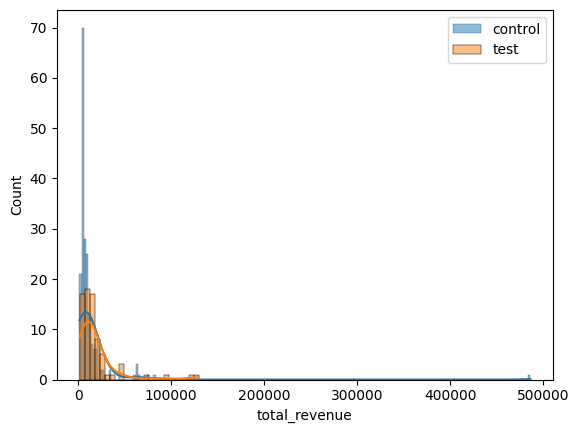

In [85]:
sns.histplot(control_group.query('product_type == "premium_no_trial"').total_revenue, label='control', kde=True)
sns.histplot(test_group.query('product_type == "premium_no_trial"').total_revenue, label='test', kde=True)
plt.legend();

По данному графику можно увидеть, что плотность распределения выручки на пользователя в тестовой группе стало более смещенным вправо от нуля. Визуально видно, что оба распределения не являются нормальными, в чем убедимся далее с помощью специальных методов.

In [86]:
pg.normality(data=all_data, dv='total_revenue', group='exp_group', method='normaltest')

,W,pval,normal
exp_group,,,
control,18346.411018,0.0,False
test,6348.869633,0.0,False


Проверим также нормальность распределения ARPU и ARPPU в тестовой и контрольной группах с помощью теста Шапиро-Уилка

In [87]:
# ARPU
control = control_group['total_revenue']
test = test_group['total_revenue']

test_stat, pvalue = ss.shapiro(control)
print(f'p-value по ARPU в контрольной группе = {pvalue:.5f}')
test_stat, pvalue = ss.shapiro(test)
print(f'p-value по ARPU в тестовой группе = {pvalue:.5f}')

p-value по ARPU в контрольной группе = 0.00000
p-value по ARPU в тестовой группе = 0.00000


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [88]:
# ARPPU
control = control_group[control_group['total_revenue'] > 0].total_revenue
test = test_group[test_group['total_revenue'] > 0].total_revenue

test_stat, pvalue = ss.shapiro(control)
print(f'p-value по ARPPU в контрольной группе = {pvalue:.5f}')
test_stat, pvalue = ss.shapiro(test)
print(f'p-value по ARPPU в тестовой группе = {pvalue:.5f}')

p-value по ARPPU в контрольной группе = 0.00000
p-value по ARPPU в тестовой группе = 0.00000


Будем использовать t-тест для сравнения средних в качестве основного теста, а также посмотрим, как результат согласуется с результатом бутстрэпа.

In [89]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95, # уровень значимости
    name = ''
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50, color = 'red', alpha = 0.3)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--', color = 'red')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title(f"Histogram of boot_data for {name}")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2038.59it/s]


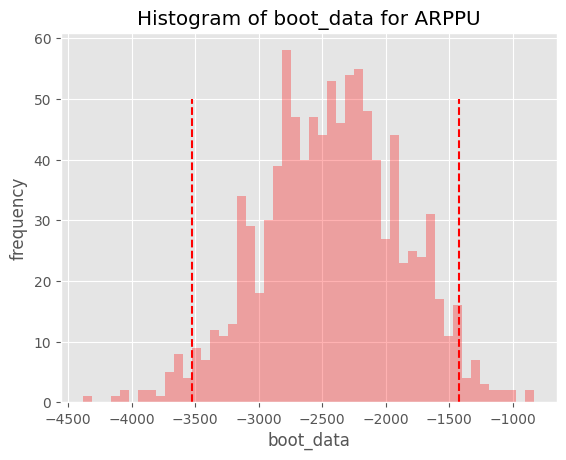

p-value : 0.000182943735915


In [102]:
#ARPPU
control = control_group[control_group['total_revenue'] > 0]['revenue']
test = test_group[test_group['total_revenue'] > 0]['revenue']

booted_data_mean = get_bootstrap(control, test, 1000, name = 'ARPPU')
print(f"p-value : {round(ss.ttest_ind(control, test,alternative='two-sided')[1],15)}")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.14it/s]


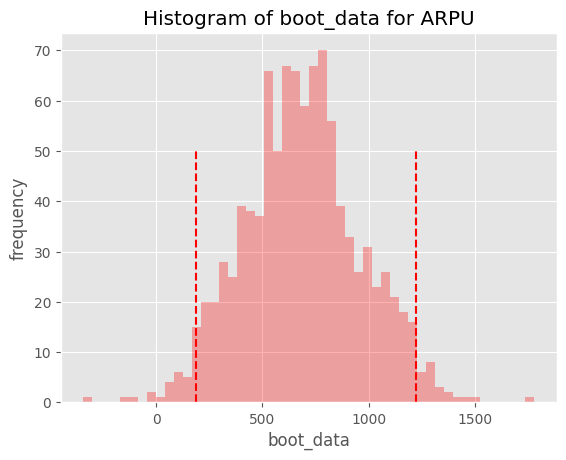

p-value : 0.0645919337


In [103]:
#ARPU
control = control_group.total_revenue
test = test_group.total_revenue

booted_data_mean = get_bootstrap(control, test, 1000, name = 'ARPU')
print(f"p-value : {round(ss.ttest_ind(control, test, alternative='two-sided')[1],10)}")

Как видим, p-value для ARPPU меньше 0.05 и доверительный интервал не захватывает нулевое значение. ARPPU является для нас интересным показателем, так как рассматривает платящих пользователей, составляющих меньшую часть от общего количества пользователей подобных сервисов, и вместе с тем основным источником дохода для компании. Важно выяснить, как увеличение стоимости подписки будет влиять на среднюю выручку с платящего пользователя, так как вряд ли повышение стоимости подписки может положительно повлиять на неплатящих пользователей.

ARPU при этом статистически значимо не изменилось.

Таким образом, можно сделать вывод, что обнаружены статистически значимые отличия по данным метрикам между тестовой и контрольной выборкой, есть основания отклонить H0 (отличий нет) в пользу H1 (в тестовой выборке выше показатель по выручке на платящего пользователя )


## 6. Конверсия в премиум 

Проверим дополнительно конверсию в премиум пользователей. Отметим пользователей, купивших премиум хотя бы один раз за время эксперимента

In [104]:
prem_no_trial_lst = all_data.query('product_type == "premium_no_trial"').uid.unique()

In [105]:
all_data['premium_no_trial'] = all_data.uid.apply(lambda x: 1 if x in prem_no_trial_lst else 0)

В качестве статистического критерия будем использовать хи-квадрат

In [106]:
all_test = all_data[all_data.exp_group == 'test']
all_control = all_data[all_data.exp_group == 'control']

In [107]:
expected, observed, stats = chi2_independence(all_data, x= 'premium_no_trial', y = 'exp_group')

In [108]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.920504,1.0,0.001634,0.027929,0.882922
1,cressie-read,0.666667,10.032930,1.0,0.001538,0.028087,0.886383
2,log-likelihood,0.000000,10.274807,1.0,0.001349,0.028423,0.893521
3,freeman-tukey,-0.500000,10.471963,1.0,0.001212,0.028695,0.899036
4,mod-log-likelihood,-1.000000,10.683496,1.0,0.001081,0.028983,0.904665
5,neyman,-2.000000,11.153178,1.0,0.000839,0.029614,0.916156


In [109]:
expected

exp_group,control,test
premium_no_trial,,
0,8148.624627,4049.375373
1,347.375373,172.624627


In [110]:
observed

exp_group,control,test
premium_no_trial,,
0,8115.5,4082.5
1,380.5,139.5


In [111]:
cr_control = round(observed.control[1]/observed.control[0]*100,2)

In [112]:
cr_test = round(observed.test[1]/observed.test[0]*100,2)

Значение p-value меньше уровня значимости, следовательно, конверсия не равна. Можно заметить, что в тестовой группе она ниже. Посчитаем:

In [113]:
print(f'Конверсия в премиум в контрольной группе - {cr_control}% , в тестовой - {cr_test}%')

Конверсия в премиум в контрольной группе - 4.69% , в тестовой - 3.42%


Отметим, что полученные значения по конверсии согласуются с полученными другим способом в п.5

## Выводы

Целью эксперимента было проверить, влияет ли увеличение стоимости премиум-подписки для новых пользователей на общую выручку компании. Для этого проверялись в совокупности такие метрики, как средняя выручка на платящего пользователя, ARPU, ARPPU, CR.

По ходу работы были сделаны следующие выводы:

-Данные подготовлены не идеально, в них присутствуют дубликаты, а также пользователи, не попадающие в рассматриваемый временной диапазон.

-Была обнаружена ошибка фиксации даты платежей, в некоторых транзакциях автоматическая система считывает месяц как день и наоборот.

-Было обнаружено несоответствие суммы выручки на пользователя в "транзакциях" и в "пользователях", стоит обратить внимание на данную ошибку сбора данных

-Разделение по группам было честным и равномерным по основным признакам

-Группы засплитованы корректно по результатам A/A теста

-Изменение стоимости премиум-подписки значимо отразилось на метрике ARPPU в тестовой группе 

-Изменение стоимости премиум-подписки не привело к увеличению конверсии пользователей в премиум

**Был ли эксперимент успешен в целом?**

В целом эксперимент можно назвать успешным, если рассматриваемая метрика - увеличение средней выручки на платящего пользователя. При этом нужно учитывать, что конверсия снизилась(c 4,4% до 3,4%) и в некоторой степени это нивелирует позитивный эффект от повышения ARPPU.